# Tester notebook for RCC

In [13]:
import xarray as xr
import rioxarray
import matplotlib.pyplot as plt
import geopandas as gpd
from shapely.geometry import mapping
from tqdm import tqdm
import pandas as pd

#from clustering import *
from radially_constrained_cluster import *

In [14]:
italy_region = gpd.read_file('/work/users/jgrassi/data/italy.shp')

def plot_map(geo_df, column_to_color, cmap, vmin, vmax, title):

    # Defining the figure
    fig, ax = plt.subplots(1,1, figsize=(6,6)) 

    
    # Plot the map
    cax = geo_df.plot(column=column_to_color, cmap=cmap, ax=ax, legend=False, vmin=vmin, vmax=vmax)

    # Adding regional boundaries
    italy_region.boundary.plot(color = 'k', linewidth = 0.5, label = 'Regioni', ax=ax)

    # Customize the axes
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.set_xlabel('Longitude [°E]')
    ax.set_ylabel('Latitude [°N]')
    ax.grid(alpha=0.3)

    # Creating a custom colorbar
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=vmin, vmax=vmax))
    sm._A = []
    cbar = fig.colorbar(sm, ax=ax)

    ax.set_title(title)

    return ax, fig, cbar

In [15]:
data_path = '/work/users/jgrassi/data/ERA5'

data_obj = []

for files in ['2m_temperature/temperature_*.nc', 'total_precipitation/precipitation_*.nc']:

    obj = xr.open_mfdataset(rf'{data_path}/{files}')
    obj = obj.convert_calendar('noleap').rolling(time=10*24, center=True).mean().load()

    obj.rio.set_spatial_dims(x_dim="longitude", y_dim="latitude", inplace=True)
    obj.rio.write_crs("epsg:4326", inplace=True)

    data_obj.append(obj)

  0%|          | 0/20 [00:00<?, ?it/s]

(365, 340)


  5%|▌         | 1/20 [00:30<09:47, 30.91s/it]

(365, 580)


 10%|█         | 2/20 [01:04<09:50, 32.78s/it]

(365, 360)


 15%|█▌        | 3/20 [01:34<08:54, 31.42s/it]

(365, 500)


 20%|██        | 4/20 [02:08<08:36, 32.27s/it]

(365, 480)


 25%|██▌       | 5/20 [02:40<08:04, 32.32s/it]

(365, 780)


 30%|███       | 6/20 [03:17<07:55, 33.96s/it]

(365, 280)


 35%|███▌      | 7/20 [03:47<07:02, 32.47s/it]

(365, 620)


 40%|████      | 8/20 [04:21<06:37, 33.14s/it]

(365, 200)


 45%|████▌     | 9/20 [04:49<05:44, 31.31s/it]

(365, 920)


 50%|█████     | 10/20 [05:28<05:38, 33.81s/it]

(365, 340)


 55%|█████▌    | 11/20 [05:57<04:50, 32.32s/it]

(365, 180)


 60%|██████    | 12/20 [06:24<04:05, 30.64s/it]

(365, 860)


 65%|██████▌   | 13/20 [07:03<03:52, 33.22s/it]

(365, 840)


 70%|███████   | 14/20 [07:45<03:36, 36.02s/it]

(365, 880)


 75%|███████▌  | 15/20 [08:26<03:07, 37.48s/it]

(365, 820)


 80%|████████  | 16/20 [09:06<02:31, 37.99s/it]

(365, 520)


 85%|████████▌ | 17/20 [09:38<01:49, 36.39s/it]

(365, 300)


 90%|█████████ | 18/20 [10:07<01:08, 34.22s/it]

(365, 100)


 95%|█████████▌| 19/20 [10:33<00:31, 31.61s/it]

(365, 660)


100%|██████████| 20/20 [11:09<00:00, 33.48s/it]


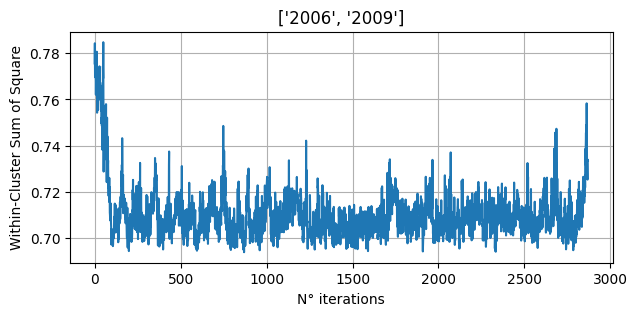

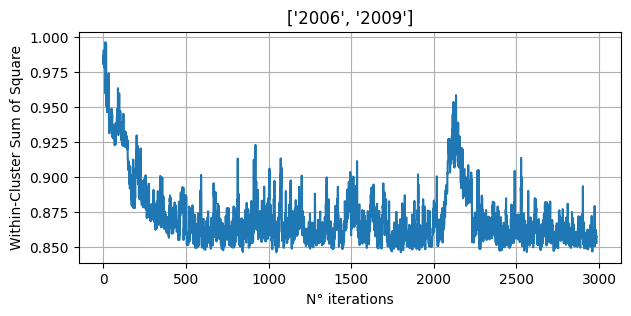

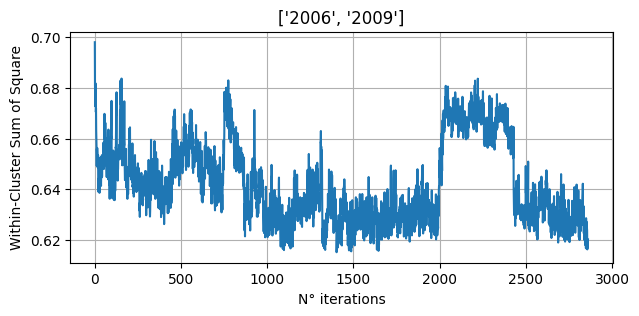

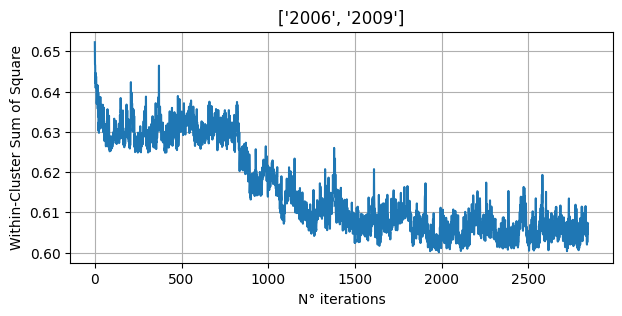

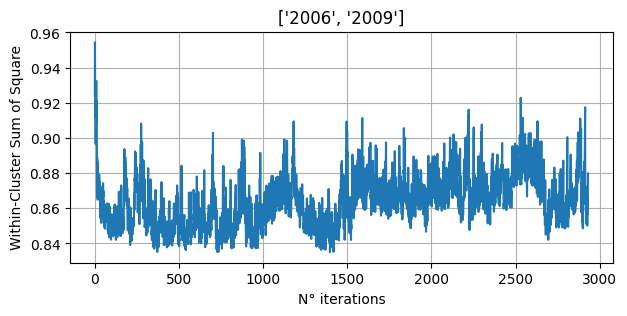

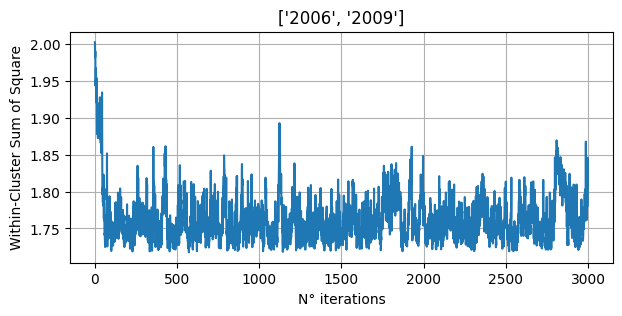

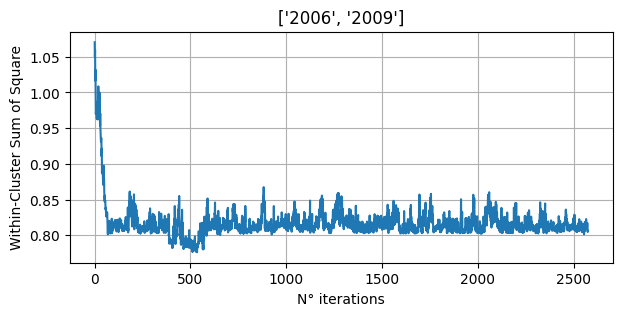

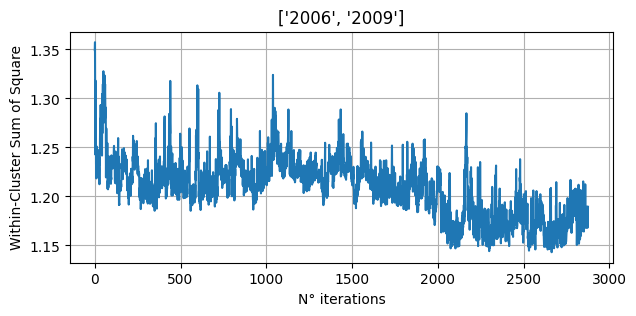

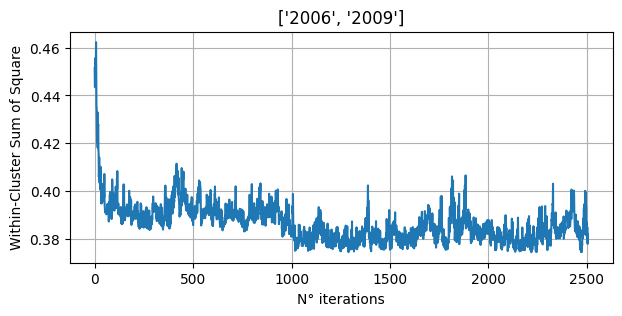

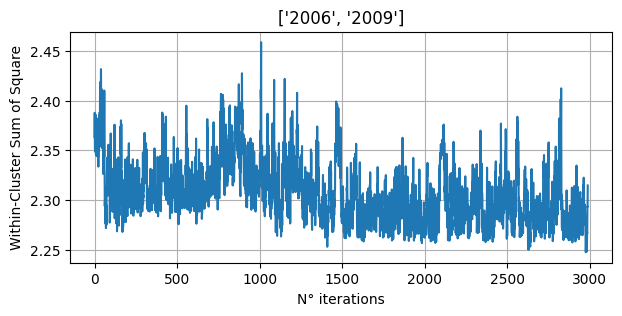

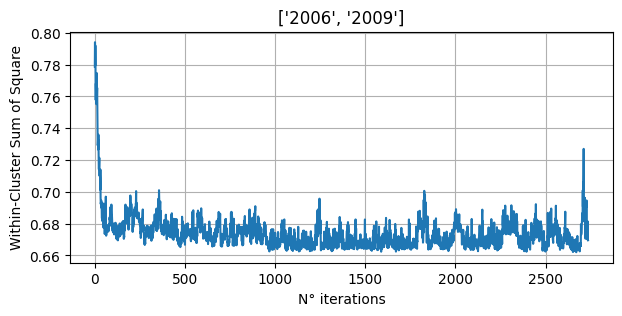

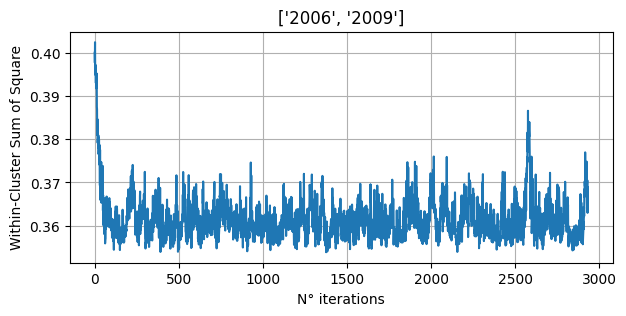

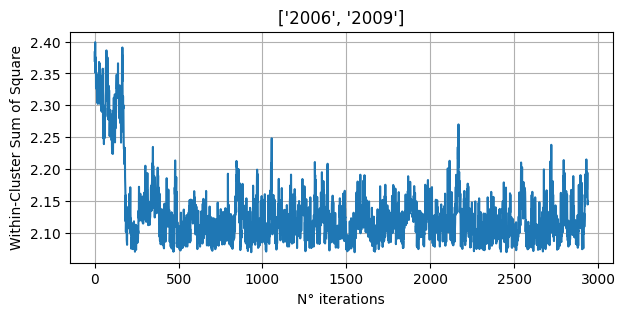

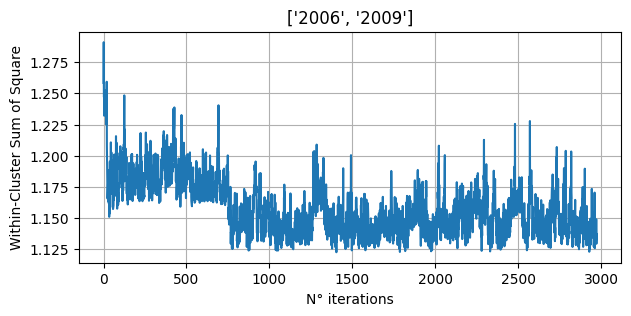

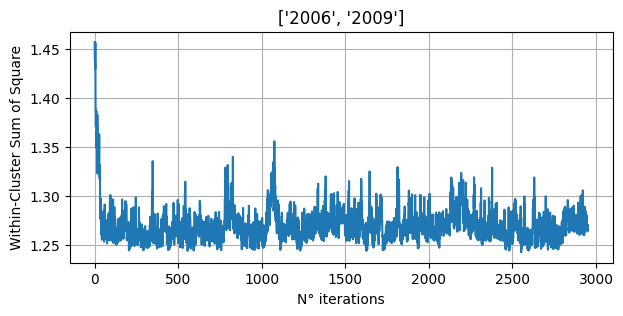

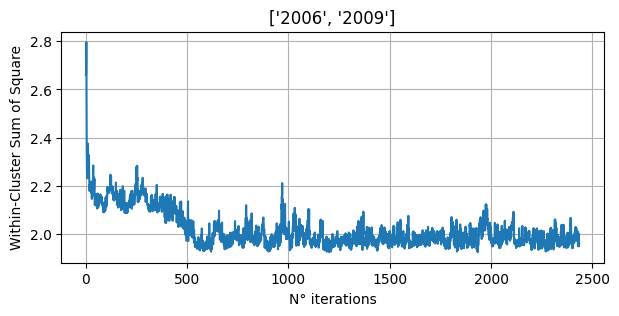

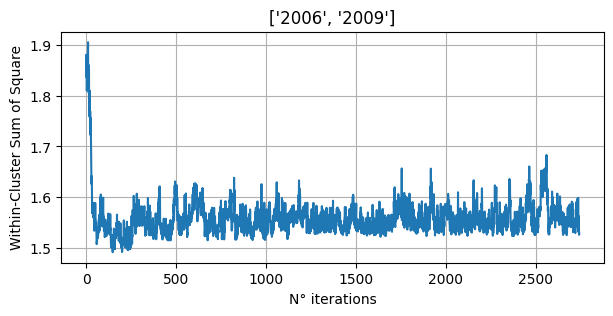

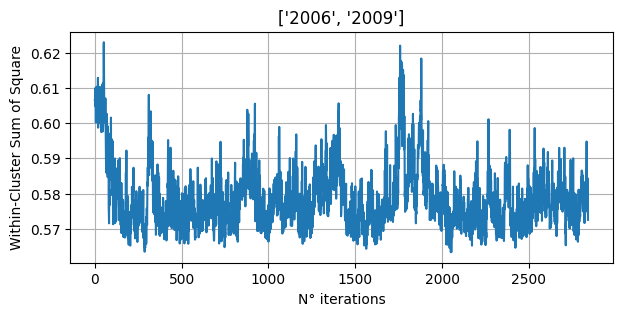

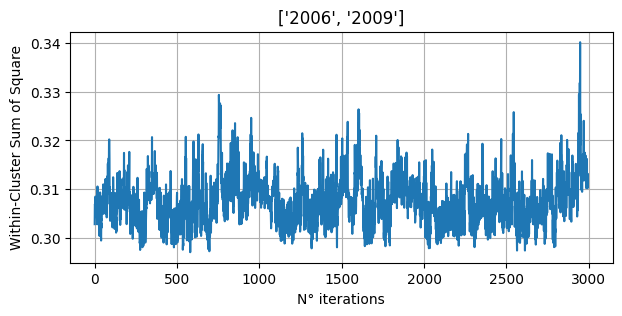

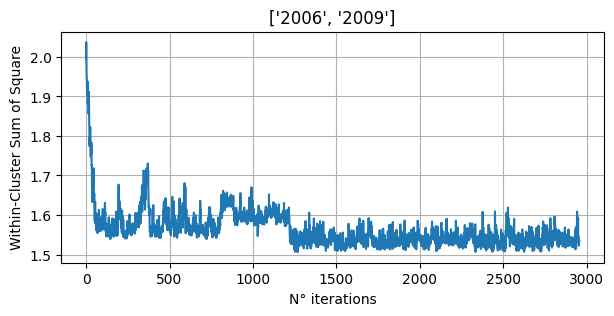

In [16]:
italy_region = gpd.read_file('/work/users/jgrassi/data/italy.shp')


periods = [['1979','1982'],['1982','1985'],['1985','1988'],['1988','1991'],['1991','1994'],['1994','1997'],['1997','2000'],['2000','2003'],['2003','2006'],['2006','2009']]

bp_macro = []
tot = []

for j in tqdm(range(20)):

    gpp = italy_region.loc[j]
    new = gpd.GeoDataFrame(gpp)
    new.columns = ['geometry']
    gdf = new.set_geometry('geometry')


    arrays = []

    for obj, var in zip(data_obj, ['t2m','tp','sfcWind']):

        for j in periods:

            obj_rast = obj.sel(time=slice(j[0], j[1]))
            obj_rast = obj_rast.groupby('time.dayofyear').mean()
            obj_rast = obj_rast.rio.clip(gdf.geometry.apply(mapping), gdf.crs, drop=True)

            obj_array = obj_rast[var].to_numpy()
            obj_array = np.reshape(obj_array, (365, obj_array.shape[1]*obj_array.shape[2]))
            arrays.append(obj_array)



    # concatenate the two arrays on columns
    array_tot = np.concatenate((arrays), axis=1)
    array_tot = array_tot[:,~np.all(np.isnan(array_tot), axis=0)]
    print(array_tot.shape)

    # min-max normalization on axis 1
    array_tot = (array_tot - array_tot.min(axis=1).reshape(-1, 1)) / (array_tot.max(axis=1) - array_tot.min(axis=1)).reshape(-1, 1)


    model = Radially_Constrained_Cluster(data_to_cluster = array_tot,
                                     n_seas = 4,
                                     n_iter = 3000,
                                     learning_rate = 3,
                                     min_len=50,
                                     mode = 'single')

    model.fit()

    fig_learning = plt.figure(figsize = (7,3))
    plt.plot(model.error_history)
    plt.grid()
    plt.title(j)
    plt.xlabel('N° iterations')
    plt.ylabel('Within-Cluster Sum of Square')

    gdf['spring_onset'] = model.breakpoints[0]
    gdf['summer_onset'] = model.breakpoints[1]
    gdf['autumn_onset'] = model.breakpoints[2]
    gdf['winter_onset'] = model.breakpoints[3]

    gdf['spring_lenght'] = model.breakpoints[1] -model.breakpoints[0]
    gdf['summer_lenght'] = model.breakpoints[2] -model.breakpoints[1]
    gdf['autumn_lenght'] = model.breakpoints[3] -model.breakpoints[2]
    gdf['winter_lenght'] = 365 - model.breakpoints[3] + model.breakpoints[0]

    tot.append(gdf)

tot = pd.concat(tot)

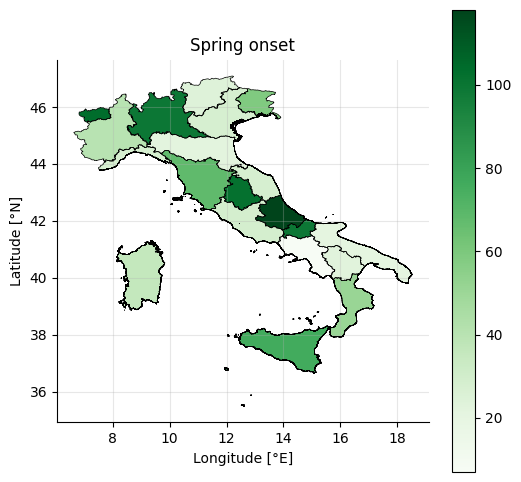

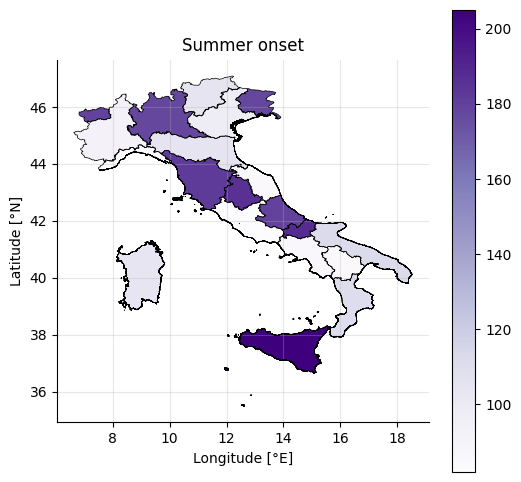

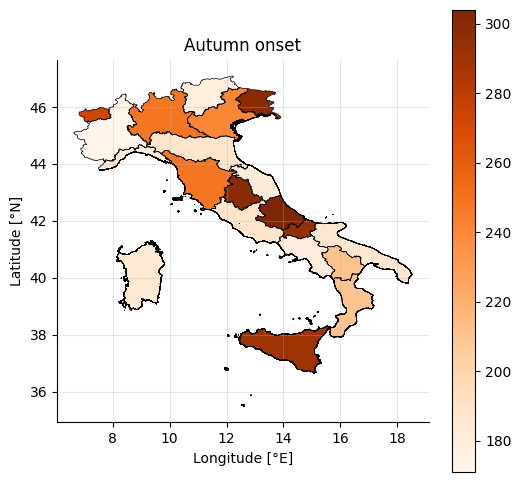

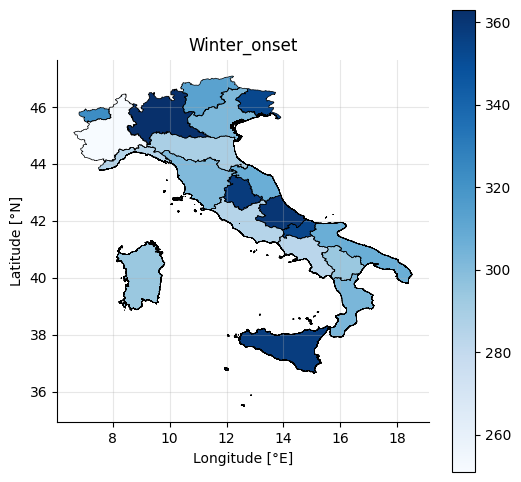

In [17]:
for onset, title, cmap in zip(['spring_onset','summer_onset','autumn_onset','winter_onset'],
                            ['Spring onset','Summer onset','Autumn onset','Winter_onset'],
                            ['Greens', 'Purples','Oranges','Blues']):
    
    fig, ax, cbar = plot_map(tot, onset, cmap, tot[onset].min(), tot[onset].max(), title)


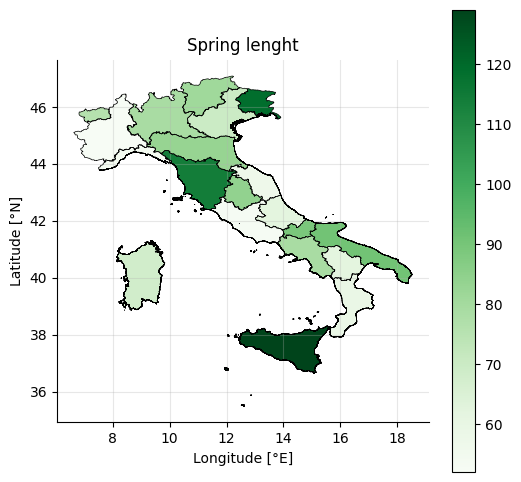

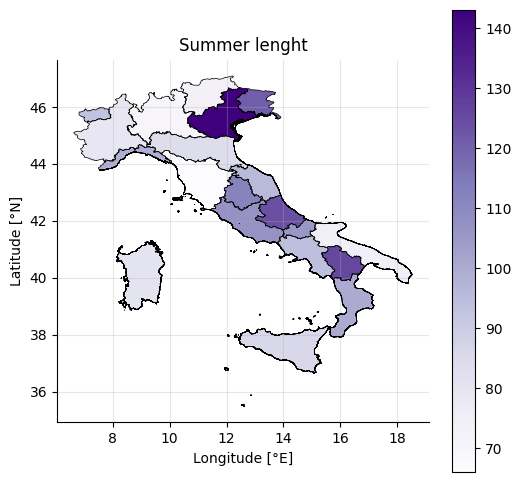

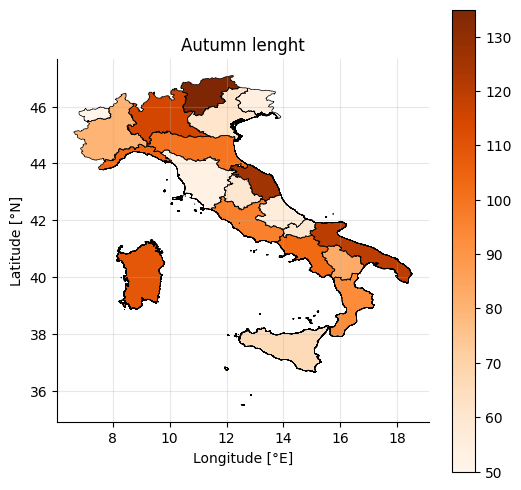

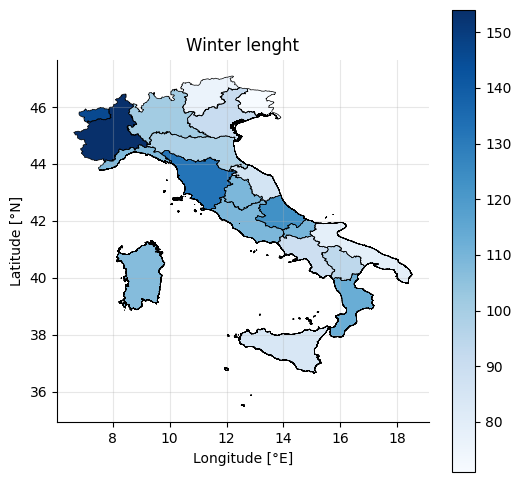

In [18]:
for lenght, title, cmap in zip(['spring_lenght','summer_lenght','autumn_lenght','winter_lenght'],
                            ['Spring lenght','Summer lenght','Autumn lenght','Winter lenght'],
                            ['Greens', 'Purples','Oranges','Blues']):
    
    fig, ax, cbar = plot_map(tot, lenght, cmap, tot[lenght].min(), tot[lenght].max(), title)


In [19]:
tot

,geometry,spring_onset,summer_onset,autumn_onset,winter_onset,spring_lenght,summer_lenght,autumn_lenght,winter_lenght
geometry,"POLYGON ((14.28018 41.91049, 14.27131 41.90198...",118,180,304,360,62,124,56,123
geometry,"MULTIPOLYGON (((18.39375 39.86014, 18.39319 39...",21,112,187,307,91,75,120,79
geometry,"MULTIPOLYGON (((16.10554 39.90751, 16.10519 39...",23,85,211,294,62,126,83,94
geometry,"MULTIPOLYGON (((16.12486 37.99847, 16.12486 37...",51,110,210,303,59,100,93,113
geometry,"MULTIPOLYGON (((15.44597 40.01931, 15.44597 40...",7,86,180,283,79,94,103,89
geometry,"MULTIPOLYGON (((12.50403 44.11514, 12.50403 44...",22,105,189,289,83,84,100,98
geometry,"MULTIPOLYGON (((13.72181 45.59681, 13.72153 45...",59,178,299,353,119,121,54,71
geometry,"MULTIPOLYGON (((13.45764 40.79125, 13.45792 40...",29,82,189,285,53,107,96,109
geometry,"MULTIPOLYGON (((7.69958 43.79792, 7.69931 43.7...",28,82,181,285,54,99,104,108
geometry,"MULTIPOLYGON (((9.29867 44.75333, 9.2991 44.75...",99,178,248,363,79,70,115,101
